In [0]:
%tensorflow_version 1.4.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [0]:
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os

In [0]:
orig_dir = '/content/gdrive/My Drive/NEUTROPHIL/Train/32/32'
print('total images:', len(os.listdir(orig_dir)))
temp = os.listdir(orig_dir)

total images: 4002


In [0]:
import tensorflow
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
train_dir_in = '/content/gdrive/My Drive/NEUTROPHIL/Train/32'


# Flow training images in batches of 20 using train_datagen generator
image_generator = train_datagen.flow_from_directory(
        train_dir_in,  # This is the source directory for training images
        target_size=(32, 32),  # All images will be resized to 32x32
        batch_size= 32,
        color_mode="rgb",
        class_mode=None,
        shuffle=False
        # Since we use binary_crossentropy loss, we need binary labels
        )


Found 4002 images belonging to 1 classes.


Using TensorFlow backend.


In [0]:
im_A_train = image_generator[0]
print(im_A_train.shape)

(32, 32, 32, 3)


In [0]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Layer, Input, Lambda 
from keras.layers import Multiply, Add, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Convolution2D, LeakyReLU, Flatten, ReLU


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist
from keras import backend as K
from scipy.stats import norm

import matplotlib.image as mpimg
import sys

from tqdm import tqdm_notebook
from IPython import display
%matplotlib inline

from keras import initializers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D

In [0]:
import keras
from keras.datasets import cifar10, cifar100
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as ktf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

batchsizeX = 32
datalengthx = 4002
batchsizey =32
datalengthy = 1248

class DataLoader():
  def __init__(self, dataset_name, img_res=(32, 32)):
    #self.dataset_name = dataset_name
    self.img_res = img_res
    #self.load_dataset()
    
  def get_dataset_shape(self, is_training=True):
    if is_training:
      return (4002,32,32,3)
    else:
      return (1248,32,32,3)
    
  def get_num_batches(self, batch_size):
    return 32
    
  def set_image_transformations(self, convert_to_bw):
    
    self.convert_to_bw = convert_to_bw
  
  def load_batch(self, batch_size=1, is_training=True):  
    if is_training:    
      
      num_batches = 126
    else:
      num_batches = 39 
    for idx_batch in range(num_batches):    
      if is_training:
        batch = image_generator[idx_batch]
      else:
        batch = image_generator2[idx_batch]
      batch = batch.astype('float32')
      #batch /= 255
      batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))       
      # Convert to mask
      batch_bw = self.convert_to_bw(batch)
      yield [batch, batch_bw]

  def get_random_batch(self, batch_size=1, is_training=True):
    
    if is_training:
      idx = random.randint(0, 124)
      batch = image_generator[idx]
      batch = batch[0:batch_size]
    else:
      idx = random.randint(0, 38)
      batch = image_generator2[idx]
      batch = batch[0:batch_size]

    batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
        
    # Convert to B&W
    batch_bw = self.convert_to_bw(batch)
      
    return [batch, batch_bw]


In [0]:
dataset_loader = DataLoader(dataset_name = 'MYDATA')
training_shape = dataset_loader.get_dataset_shape()
test_shape = dataset_loader.get_dataset_shape(is_training=False)

print('Shape of Training Images: {}'.format(training_shape))
print('Shape of Test Images: {}'.format(test_shape))

Shape of Training Images: (4002, 32, 32, 3)
Shape of Test Images: (1248, 32, 32, 3)


In [0]:
import numpy as np
from numpy import isneginf
from scipy.stats import iqr 

def compute_mag_phase(toBeTransfromed):
    dft = np.fft.fft2(toBeTransfromed)
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    ang = np.angle(dft_shift)
    return mag, ang

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    #combinedReal = np.real(combined)
    #combinedImag = np.imag(combined)
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined

In [0]:
import random
np.random.seed(100)

noise_mag = np.random.uniform(size = (32,32,3),low = 0.0, high = 1.0)
#print(noise_mag[0])

In [0]:
def transformx(img):
    mag,ang = compute_mag_phase(img)
    im = reconstruct(noise_mag,ang)
    return im 

def reconstructAll(imgArray):
    #print(imgArray.shape)
    batch = np.zeros(imgArray.shape)
    for i in range(0,imgArray.shape[0]):
      imgx = imgArray[i,:,:,:]
      #print(imgx.shape)
      batch[i,:,:,:] = transformx(imgArray[i,:,:,:])
    #print(batch.shape)
    return batch

In [0]:

dataset_loader.set_image_transformations(reconstructAll)

In [0]:
random_batch = dataset_loader.get_random_batch(batch_size=9)
print(random_batch[0])

[[[[0.7490196  0.8000001  0.7725491 ]
   [0.7686275  0.8117648  0.78823537]
   [0.76470596 0.8000001  0.7803922 ]
   ...
   [0.02745098 0.         0.03137255]
   [0.03921569 0.00784314 0.05882353]
   [0.01568628 0.         0.03529412]]

  [[0.7372549  0.7803922  0.7568628 ]
   [0.76470596 0.8000001  0.7803922 ]
   [0.7803922  0.80392164 0.78823537]
   ...
   [0.01176471 0.         0.01960784]
   [0.02745098 0.00392157 0.04313726]
   [0.02745098 0.00392157 0.04313726]]

  [[0.7372549  0.7725491  0.75294125]
   [0.7686275  0.79215693 0.77647066]
   [0.79215693 0.8117648  0.7960785 ]
   ...
   [0.         0.         0.00784314]
   [0.         0.         0.00784314]
   [0.         0.         0.00784314]]

  ...

  [[0.07843138 0.05490196 0.0627451 ]
   [0.01176471 0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.7843138  0.74509805 0.7490196 ]
   [0.7058824  0.6666667  0.6627451 ]
   [0.6431373  0.6117647  0.6       ]]

  [[0.         0.00392157 0.        ]
   [0. 

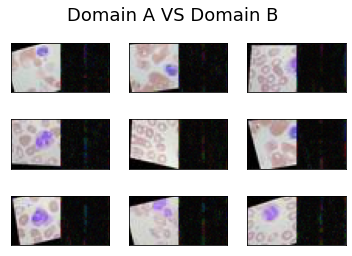

In [0]:
random_batch = dataset_loader.get_random_batch(batch_size=9)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 1, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Domain A VS Domain B', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    #print(tmp[idx].shape)
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
from keras.layers import Dropout, merge, concatenate, UpSampling2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Reshape, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, Input, Dense, Reshape, Flatten
from keras.optimizers import Adam

def build_generator(im_shape):
  #print(im_shape)
  
  img_B = Input(shape=(im_shape[0], im_shape[1], 3))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(img_B)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = img_B, outputs = conv10, name='generator')
  
  return model

In [0]:
def build_discriminator(im_shape):
  
  img_A = Input(shape=(im_shape[0], im_shape[1], 3))
  img_B = Input(shape=(im_shape[0], im_shape[1], 3))

  combined_imgs = concatenate([img_A, img_B], axis=-1)
    
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(combined_imgs)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)

  disc_layer = Conv2D(128, kernel_size=(5, 5), strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Flatten()(disc_layer)
  disc_layer = Dense(1024)(disc_layer)

  prob = Dense(1, name="disc_dense")(disc_layer)

  discriminator = Model(inputs=[img_A, img_B], outputs=[prob], name='discriminator')
  
  return discriminator

In [0]:
# Define optimizers for each network.
# Note that if the discriminator is able to differentiate between samples, 
# the generator will be not able to learn. They must learn at the same time.
# Setting the learning rates or learning steps is always tricky.
optimizer_g = Adam(0.0002, 0.5)
optimizer_d = Adam(0.00002, 0.5)

# Input size
im_shape = (32, 32)

# Build and compile the discriminator
discriminator = build_discriminator(im_shape)
discriminator.compile(loss='mse', optimizer=optimizer_d, metrics=['accuracy'])

# Build the generator
generator = build_generator(im_shape)

# Input images and their conditioning images
img_A = Input(shape=(im_shape[0], im_shape[1], 3))
img_B = Input(shape=(im_shape[0], im_shape[1], 3)) ####

# By conditioning on B generate a fake version of A.
# Remember, images in B are the B&W version of images in A
fake_A = generator(img_B)

# For the combined model we will only train the generator, thus, we freeze the
# discriminator model when optimizing G.
# We are backpropagating the discriminator's error
# into the generator in order to create fake images that are unrecognizable by D
discriminator.trainable = False

# Discriminators determines if a conditioned pair has been generated or is real
valid = discriminator([fake_A, img_B])

# Minimize discriminator error (only updating generator's weights) and 
# the L1 loss between real and fake images.
combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer_g)

In [0]:
def showColoredIms(imB, fake_imA, real_imA):
  
  plt.subplot(131)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('Domain B', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(132)
  plt.imshow(np.clip(fake_imA[0], 0, 1)) 
  plt.title('Fake A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(133)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

def showColored_two_models_Ims(imB, fake_imA_MAE, fake_imA_cGAN, real_imA):
  
  plt.subplot(141)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('BW', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(142)
  plt.imshow(np.clip(fake_imA_MAE[0], 0, 1)) 
  plt.title('MAE', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(143)
  plt.imshow(np.clip(fake_imA_cGAN[0], 0, 1))
  plt.title('cGAN', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(144)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


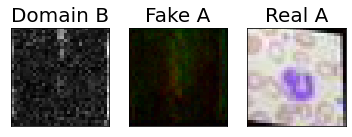

[Epoch 0/20] [Batch 0/32] [D loss: 1.695254, acc:  17%] [G loss: 66.403244] elapsed_time: 0:00:10.784965  remaining_time: 0:05:34.333915


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/20] [Batch 10/32] [D loss: 0.610361, acc:  45%] [G loss: 39.883518] elapsed_time: 0:01:19.702921  remaining_time: 0:02:32.160120
[Epoch 0/20] [Batch 20/32] [D loss: 0.679570, acc:  38%] [G loss: 31.236872] elapsed_time: 0:03:40.131141  remaining_time: 0:01:55.306785


KeyboardInterrupt: ignored

In [0]:
num_epochs = 20
batch_size = 32
n_batches = dataset_loader.get_num_batches(batch_size)

# Adversarial loss ground truths. 
# They are used as labels for the discriminator loss.
valid = np.ones((batch_size,))
fake = np.zeros((batch_size,))
     
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []
  d_avg_loss = []
  d_avg_acc = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size)):
      
    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Condition on B and generate a translated (fake) version of A.
    # It will try to color images from B to be as similiar as possible 
    # to their correspoding pairs from A.
    fake_A = generator.predict(imgs_B)      

    # Train the discriminator (original images = real / generated = Fake)
    d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
    d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_avg_loss.append(d_loss[0])
    d_avg_acc.append(d_loss[1])
    
    # -----------------
    #  Train Generator
    # -----------------

    # Train the generators
    g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
    g_avg_loss.append(g_loss[0])
    
    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%50 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      

    # Plot the progress
    if batch_i%10 == 0:          

      print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(d_avg_loss), 100*np.mean(d_avg_acc), np.mean(g_avg_loss), elapsed_time, remaining_time))            
        
  # Saves optimizer and weights
  generator.save('generator.h5') 
  discriminator.save('discriminator.h5')